# Part 1 - Exploratory data analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load login data and prep for resampling
login_df = pd.read_json('logins.json')
login_df['logins'] = 1
login_df = login_df.set_index('login_time').sort_index()
login_df

,logins
login_time,
1970-01-01 20:12:16,1
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:36,1
1970-01-01 20:16:37,1
...,...
1970-04-13 18:48:52,1
1970-04-13 18:50:19,1
1970-04-13 18:54:02,1


In [3]:
# The large difference in max and mean values indicates that outliers are present in our dataset
login_resamp = login_df.resample('15T')['logins'].sum()
login_resamp.describe()

count    9788.000000
mean        9.515938
std         8.328818
min         0.000000
25%         3.000000
50%         7.000000
75%        13.000000
max        73.000000
Name: logins, dtype: float64

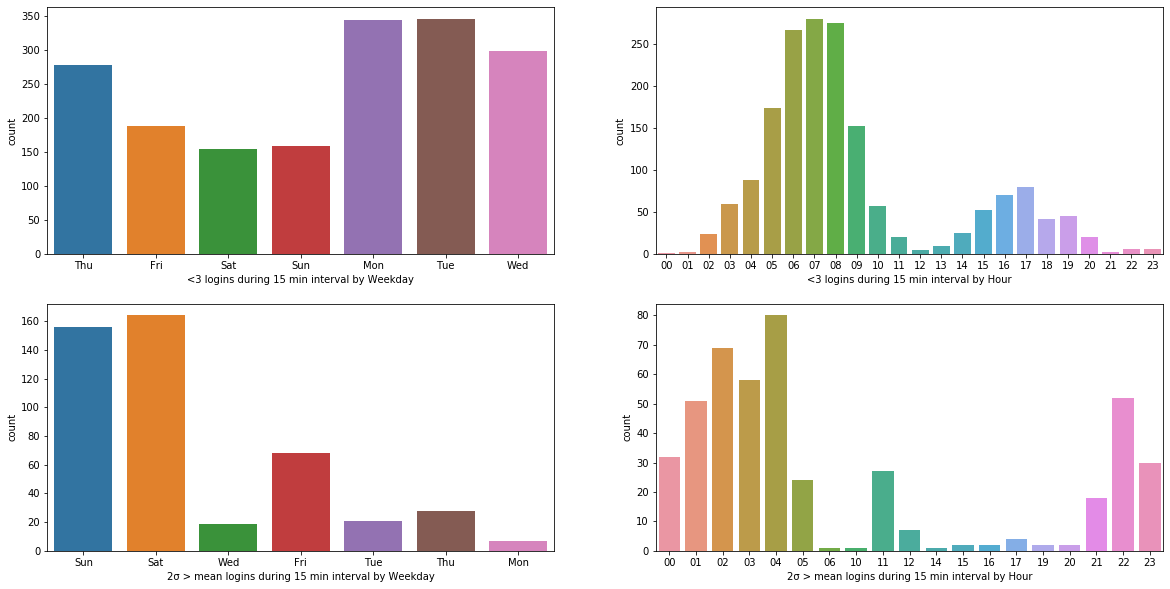

In [4]:
# We graph periods with <3 logins and logins that are >13 to look for trends in demand

resamp_low = login_resamp[login_resamp.values < 3]
resamp_high = login_resamp[login_resamp.values > 26]

fig, axes = plt.subplots(2, 2, figsize=(20, 10))
for df,i,df_label in zip([resamp_low ,resamp_high],range(2),['<3','2σ > mean']):
    for period,j,period_label in zip(['%a','%H'],range(2),['Weekday','Hour']):
        sns.countplot(df.index.strftime(period),ax=axes[i,j]).set(xlabel = '{0} logins during 15 min interval by {1}'.format(df_label,period_label) )
        
    

15 minute intervals that had less than 3 logins (low demand) were mostly during weekday morning rush hour and partly during evening rush hour. Intervals with logins that were greater than 2 standard devations away from the mean (high demand) were primarly during late night hours on weekends.

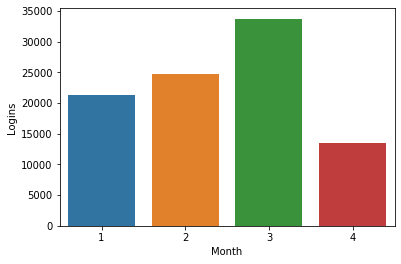

In [5]:
# Monthly Login count shows more activity as time progresses. April is lowest because it's not a complete month
month_count = login_df.resample('1M')['logins'].sum()
ax = sns.barplot(x = month_count.index.month, y = month_count.values)
ax.set(xlabel='Month', ylabel='Logins')
plt.show()

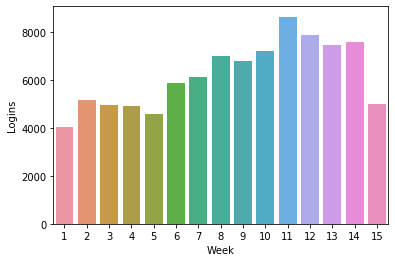

In [6]:
# Weekly data shows a similar overall rise in logins
week_count = login_df.resample('W-WED')['logins'].sum()
ax = sns.barplot(x =[_ for _ in range(1,len(week_count)+1)], y = week_count.values)
ax.set(xlabel='Week', ylabel='Logins')
plt.show()

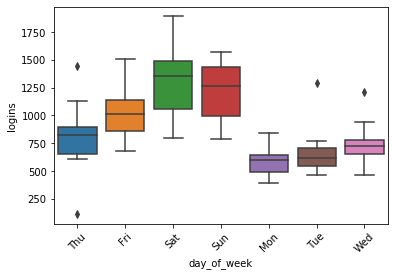

In [7]:
# Weekends/Friday are the most active
day_count = login_df.resample('1D').sum().sort_index()
day_count['date'] = day_count.index
day_count['day_of_week'] = day_count.date.apply(lambda x: x.strftime('%a'))

ax = sns.boxplot(x = day_count.day_of_week, y = day_count.logins)
plt.xticks(rotation=45)
plt.show()

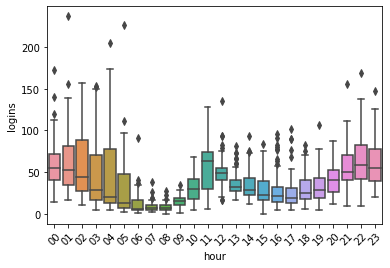

In [8]:
# Logins generally peak around 11/12 and 21/22 with 3/4 having the largest range of logins
hour_count = login_df.resample('1H').sum().sort_index()
hour_count['date'] = hour_count.index
hour_count['hour'] = hour_count.date.apply(lambda x: x.strftime('%H'))

ax = sns.boxplot(x = hour_count.hour, y = hour_count.logins)
plt.xticks(rotation=45)
plt.show()

# Part 2 ‑ Experiment and metrics design

# Part 3 ‑ Predictive modeling

In [9]:
import json
with open('ultimate_data_challenge.json') as f:
    data = json.load(f)
df = pd.DataFrame(data)
df

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,King's Landing,0,2014-01-25,5.0,1.00,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2
49996,Astapor,1,2014-01-24,NaN,1.00,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0
49997,Winterfell,0,2014-01-31,5.0,1.00,2014-05-22,Android,0.0,True,100.0,3.86,5.0
49998,Astapor,2,2014-01-14,3.0,1.00,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5


In [10]:
# We have missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [11]:
# Figuring out which users are active (last trip date is less than 30 days before most recent date)
df['last_trip_date'] = pd.to_datetime(df.last_trip_date)
df['signup_date'] = pd.to_datetime(df.signup_date)
df['active'] = df['last_trip_date'] > df['last_trip_date'].values.max() - pd.Timedelta(days = 30)
print('{:.2f} % of observed users were retained.'.format(df.active.value_counts()[1] * 100 / len(df)))

36.62 % of observed users were retained.


In [12]:
# One Hot encoding of cities and phone which keeps NaN values
# We can also drop is_Winterfell as it is encoded in the King's Landing/Astapor columns as False/False

df['phone_encoded'] = df.phone.map(dict([(v,i) for i,v in enumerate(df.phone.dropna().unique())]))
places = df.city.unique()
for place in places:
    df['is_{}'.format(place.replace("'", '').replace(" ", '_'))] = df.city == place
df = df.drop('is_Winterfell',axis = 1)
df

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active,phone_encoded,is_Kings_Landing,is_Astapor
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,True,0.0,True,False
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,False,1.0,False,True
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,False,0.0,False,True
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,True,0.0,True,False
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,False,1.0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,King's Landing,0,2014-01-25,5.0,1.00,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2,True,0.0,True,False
49996,Astapor,1,2014-01-24,NaN,1.00,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0,False,0.0,False,True
49997,Winterfell,0,2014-01-31,5.0,1.00,2014-05-22,Android,0.0,True,100.0,3.86,5.0,False,1.0,False,False
49998,Astapor,2,2014-01-14,3.0,1.00,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5,False,0.0,False,True


In [13]:
categorical = ['ultimate_black_user','phone_encoded','city','active']
numerical = ['trips_in_first_30_days','avg_rating_of_driver','avg_surge','surge_pct','weekday_pct','avg_dist','avg_rating_by_driver']

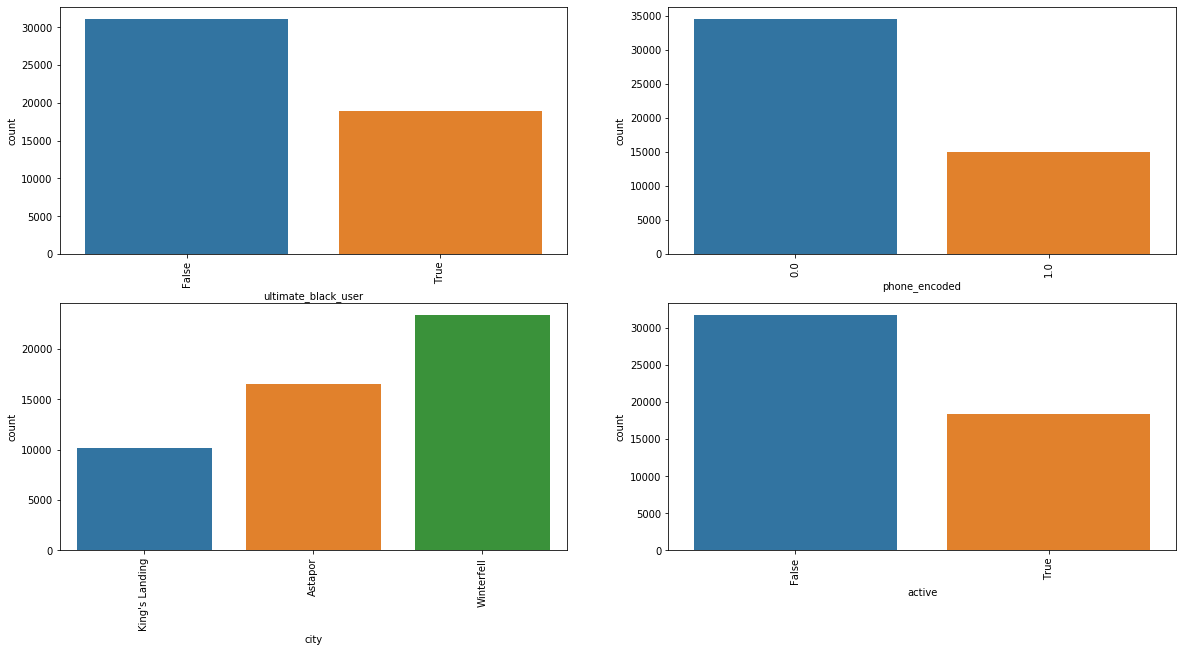

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
for variable, subplot in zip(categorical, ax.flatten()):
    sns.countplot(df[variable], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

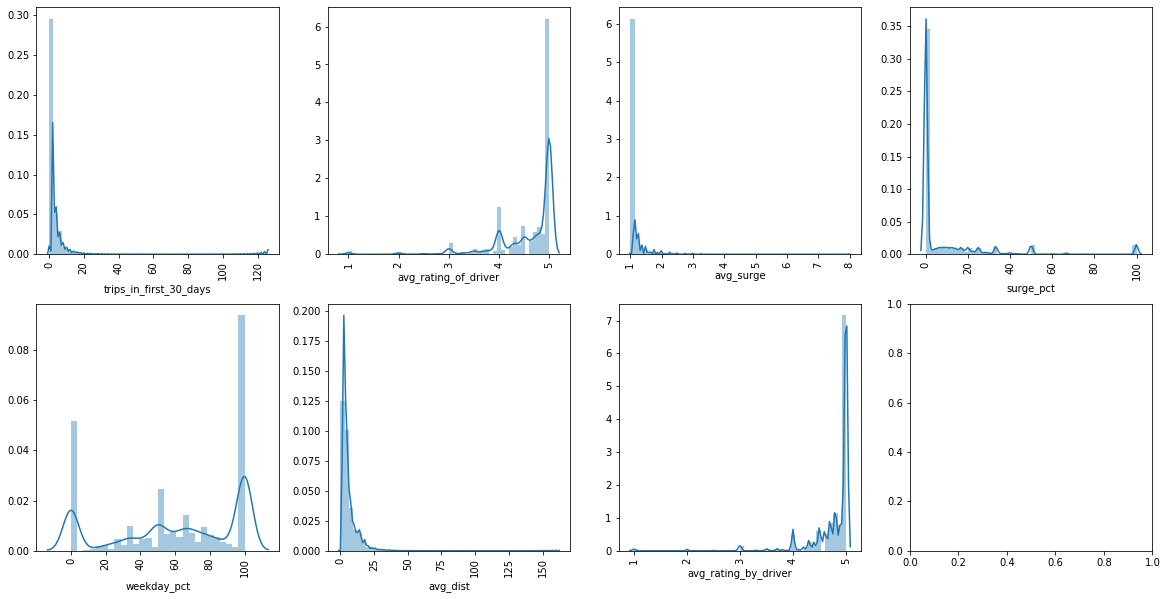

In [15]:
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
for variable, subplot in zip(numerical, ax.flatten()):
    sns.distplot(df[variable][df[variable].notnull()], hist = True, ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

In [16]:
# We use xgboost to efficiently handle NaN values and many features
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,confusion_matrix

In [17]:
features = ['trips_in_first_30_days','avg_rating_of_driver','avg_surge','surge_pct','ultimate_black_user','weekday_pct',
            'avg_dist','avg_rating_by_driver','phone_encoded','is_Kings_Landing','is_Astapor']

X = df.loc[:,features]
y = df['active']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
clf = XGBClassifier()
clf.fit(X_train,y_train)
cv_scores = cross_val_score(clf, X_train, y_train, cv=5)
print("Training accuracy with cross validation: {:.2f} %".format(np.mean(cv_scores)*100))

Training accuracy with cross validation: 79.11 %


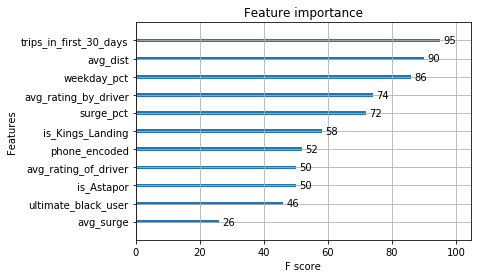

In [18]:
#Find out which features are better predictors of retention
plot_importance(clf)
plt.show()

In [19]:
# Set up our hyperparameter tuning
param_grid = {"learning_rate" : [0.05, 0.10, 0.15, 0.20] ,
 "max_depth" : [3, 4, 5],
 "min_child_weight" : [1, 3, 5],
 "gamma" : [0.0, 0.1, 0.2 , 0.3],
 "colsample_bytree" : [0.3, 0.4, 0.5] }
clf_cv = GridSearchCV(clf, param_grid, n_jobs = -1)

In [20]:
# Our model performs slightly better after tuning our parameters
clf_cv.fit(X_train, y_train)
print("Best Parameters: {}".format(clf_cv.best_params_))
print("Tuned Accuracy: {:.2f}".format(clf_cv.best_score_))
y_pred = clf_cv.predict(X_test)

Best Parameters: {'colsample_bytree': 0.5, 'gamma': 0.1, 'learning_rate': 0.15, 'max_depth': 5, 'min_child_weight': 1}
Tuned Accuracy: 0.80


In [21]:
# define function to obtain metrics on our test data
def get_scores(actual,pred):
    print('Accuracy: {:.2f} %'.format(accuracy_score(actual,pred)*100))
    print('F1 score: {:.2f}'.format(f1_score(actual,pred)))
    print('roc_auc_score: {:.2f}'.format(roc_auc_score(actual,pred)))
    print(confusion_matrix(actual,pred))

In [22]:
# Final model performance on test data set
get_scores(y_test,y_pred)

Accuracy: 79.58 %
F1 score: 0.71
roc_auc_score: 0.77
[[5461  861]
 [1181 2497]]
